In [2]:
import torch
import torch.autograd.functional as F
import torch.distributions as dist

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

In [3]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())
#plt.rcParams.update(bundles.icml2022())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'


### Parameters

In [4]:
# Prior distribution
P = torch.tensor([0.5, 0.5])

# Transition matrix
A = torch.tensor([[0.9, 0.1],
                  [0.2, 0.8]])

# States 
STATES = {0: 'Sunny', 1: 'Rainy'}

### Sampling from discrete state Markov chain

In [5]:
# Generate data from the Markov chain

def generate_data(n_samples=10, seed=0):
    torch.manual_seed(seed)
    data = torch.zeros(n_samples, dtype=torch.long)
    data[0] = dist.Categorical(P).sample()
    for i in range(1, n_samples):
        data[i] = dist.Categorical(A[data[i-1]]).sample()
    return data

def map_state(x_arr):
    return [STATES[x.item()] for x in x_arr]

In [6]:
generate_data(10, 0)
map_state(generate_data(10, 0))

['Rainy',
 'Rainy',
 'Rainy',
 'Rainy',
 'Rainy',
 'Sunny',
 'Sunny',
 'Sunny',
 'Sunny',
 'Sunny']

In [7]:
map_state(generate_data(10, 1))

['Sunny',
 'Sunny',
 'Sunny',
 'Sunny',
 'Rainy',
 'Rainy',
 'Rainy',
 'Sunny',
 'Sunny',
 'Sunny']

### Stationary distribution

In [8]:
PS = []
PR = []

In [9]:
# P(Sunny) at t=0
PS.append(P[0].item())
PS

[0.5]

In [10]:
# P (Rainy) at t=0
PR.append(P[1].item())
PR

[0.5]

In [11]:
def PS_t(t):
    return PS[t-1] * A[0, 0].item() + PR[t-1] * A[1, 0].item()

def PR_t(t):
    return PS[t-1] * A[0, 1].item() + PR[t-1] * A[1, 1].item()


In [12]:
for t in range(1, 20):
    PS.append(PS_t(t))
    PR.append(PR_t(t))


In [13]:
PS, PR

([0.5,
  0.5499999895691872,
  0.5849999801814558,
  0.609499971553684,
  0.6266499634787454,
  0.6386549558053933,
  0.647058448423374,
  0.6529408912524431,
  0.657058599234283,
  0.6599409928265687,
  0.6619586663486209,
  0.6633710358232277,
  0.6643596924658253,
  0.6650517501268584,
  0.6655361885013855,
  0.6658752933757711,
  0.6661126648003464,
  0.6662788228102565,
  0.6663951314300427,
  0.6664765454768411],
 [0.5,
  0.45000000670552254,
  0.4150000105053187,
  0.39050001224130404,
  0.37335001251176025,
  0.36134501174174294,
  0.352941510233172,
  0.34705905820045785,
  0.3429413407958347,
  0.34005893762736905,
  0.33804125442175925,
  0.33662887518843054,
  0.33564020873449596,
  0.3349481412252955,
  0.33446369297681955,
  0.33412457821043834,
  0.33388719688123464,
  0.3337210289578531,
  0.33360471041840567,
  0.333523286447613])

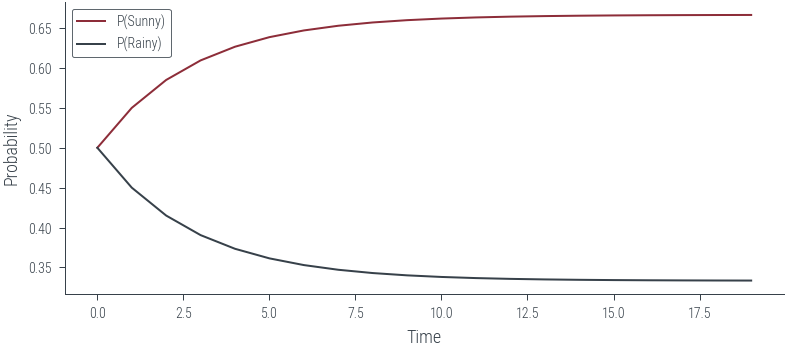

In [14]:
plt.plot(PS, label='P(Sunny)')
plt.plot(PR, label='P(Rainy)')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.legend()

In [15]:
A@A, torch.matrix_power(A, 2)

(tensor([[0.8300, 0.1700],
         [0.3400, 0.6600]]),
 tensor([[0.8300, 0.1700],
         [0.3400, 0.6600]]))

#### Vectorised version

In [16]:
# Distribution of states at t = 0
P

tensor([0.5000, 0.5000])

In [17]:
# P(Sunny) at t = 1
print("--"*20)
print("P(Sunny) at t = 1")
print(P[0] * A[0, 0] + P[1] * A[1, 0])

# P(Rainy) at t = 1
print("--"*20)
print("P(Rain) at t = 1")
print(P[0] * A[0, 1] + P[1] * A[1, 1])

# Distribution of states at t = 1
print("--"*20)
print("Distribution of states at t = 1")
print(P@A)

----------------------------------------
P(Sunny) at t = 1
tensor(0.5500)
----------------------------------------
P(Rain) at t = 1
tensor(0.4500)
----------------------------------------
Distribution of states at t = 1
tensor([0.5500, 0.4500])


In [18]:
# Distribution of states at t = 2
print("--"*20)
print("Distribution of states at t = 2")
print(P@A@A)

# Using torch.matrix_power
print("--"*20)
print("Distribution of states at t = 2")
print(P@torch.matrix_power(A, 2))

----------------------------------------
Distribution of states at t = 2
tensor([0.5850, 0.4150])
----------------------------------------
Distribution of states at t = 2
tensor([0.5850, 0.4150])


In [19]:
# convergence
P@torch.matrix_power(A, 100), P@torch.matrix_power(A, 99)

(tensor([0.6667, 0.3333]), tensor([0.6667, 0.3333]))

In [20]:
PS

[0.5,
 0.5499999895691872,
 0.5849999801814558,
 0.609499971553684,
 0.6266499634787454,
 0.6386549558053933,
 0.647058448423374,
 0.6529408912524431,
 0.657058599234283,
 0.6599409928265687,
 0.6619586663486209,
 0.6633710358232277,
 0.6643596924658253,
 0.6650517501268584,
 0.6655361885013855,
 0.6658752933757711,
 0.6661126648003464,
 0.6662788228102565,
 0.6663951314300427,
 0.6664765454768411]

In [25]:
### What if we started with different initial distribution?

P2 = torch.tensor([0.1, 0.9])
P3 = torch.tensor([0.9, 0.1])
P4 = torch.tensor([0.999999, 0.000001])

P2@torch.matrix_power(A, 100), P3@torch.matrix_power(A, 100), P4@torch.matrix_power(A, 100)

(tensor([0.6507, 0.3493]), tensor([0.6733, 0.3267]), tensor([0.6761, 0.3239]))

In [26]:
### Checking for convergence of Markov chain using iterative method

eps = 1e-6
PS = P
for i in range(100):
    PS_new = PS@A
    if torch.all(torch.abs(PS_new - PS) < eps):
        print("Converged at iteration", i)
        break
    PS = PS_new

Converged at iteration 31


In [28]:
### Checking for convergence

def check_convergence(P, A, iter=100, eps=1e-6):
    for i in range(iter):
        P_new = P@A
        if torch.all(torch.abs(P_new - P) < eps):
            print("Converged at iteration", i)
            break
        P = P_new
    return P

In [29]:
check_convergence(P, A)

Converged at iteration 31


tensor([0.6667, 0.3333])

In [30]:
check_convergence(P2, A)

Converged at iteration 34


tensor([0.6667, 0.3333])

In [31]:
check_convergence(P3, A)

Converged at iteration 32


tensor([0.6667, 0.3333])

In [32]:
check_convergence(P4, A)

Converged at iteration 33


tensor([0.6667, 0.3333])

### Homogeneous Markov chain

The transition matrix is the same for all time steps.


### Irreducible Markov chain

A Markov chain is irreducible if it is possible to get to any state from any state.

### Aperiodic Markov chain

A Markov chain is aperiodic if there are no cycles in the state transition graph.


In [ ]:
### Markov chain with aperiodic transition matrix

A = torch.tensor([[0.9, 0.1],
                    [0.2, 0.8]])






In [ ]:
### Continuous space Markov chain

def transition(a, b):
    return dist.Normal(a, 0.1).log_prob(b).exp()


